# Chapter 3 
## A Tour of machine learning classifiers using scikit-learn

### Choosing a classifier
- no free lunch theorem : no classifier works best across as datasets

5 steps to training a classifier algorithm:
1. Selecting features and collecting labeled data
2. Choosing a performance metric
3. Choosing an algorithm and training a model
4. Evaluating model performance
5. Changing model settings and tuning the model

### Using the perceptron from scikit learn

- note that the three groups of flowers are not linearly seperable
- this is a problem with the perceptron algorithm
    - it will not converge unless the data is linearly seperable

In [6]:
import numpy as np
from sklearn import  datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print(f"Class labels: {np.unique(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 1, stratify = y
)
print(f"Label counts in y: {np.bincount(y)}")
print(f"Labels counts in y_train: {np.bincount(y_train)}")
print(f"Labels counts in y_test: {np.bincount(y_test)}")

sc = StandardScaler().fit(X, y)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

ppn = Perceptron(eta0=0.1, random_state = 1).fit(X_train_std, y_train)
y_predict = ppn.predict(X_test_std)
print(f"Misclassified examples: {(y_test != y_predict).sum()}")
print(f"Accuracy: {ppn.score(X_test_std, y_test)}")

Class labels: [0 1 2]
Label counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]
Misclassified examples: 5
Accuracy: 0.8888888888888888


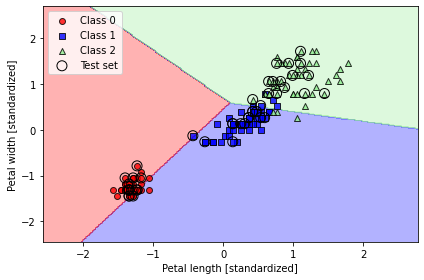

In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,resolution=0.02): # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
 
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                        c='none', edgecolor='black', alpha=1.0,
                        linewidth=1, marker='o',
                        s=100, label='Test set')

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Modeling class probabilities using logistic regression

Note that the odds of an event, $p$, is given by $\frac{p}{1-p}$

Let $x$ be a set of features and $y$ be a set of class labels.  Then the conditional probability of the label $y$, given $x$ is $p:=P(y=1|x)$.

Taking the log produces the log-odds function:
$$
    \text{logit}(p) = \log{\frac{p}{1-p}}
$$

$\text{logit}(p)$ maps the probability to $\mathbb{R}$. Assuming that there is a linear relationship between the inputs and the log-odds means:
$$
    \text{logit}(p) = \sum_{i=j} w_jx_j + b = w^Tx + b
$$

However, what is interesting is the probability of class membership given a set of features; the inverse $\text{logit}$ function can be used to produce this probability:
$$
    \sigma(z) = \frac{1}{1 + e^{-z}}
$$
Where $z$ is the new input, just as in the examples in chapter 2.

Note that, as $z \to \infty$, $\sigma(z) \to 1$ because $e^{-z} \to 0$.

#### Logistic regression and Adaline
Just as the adaline algorithm had an activation function, the logistic function has one.  The difference is that logistic regression uses the sigmoid function instead of the identity function. The output of the sigmoid function can then be interpreted as the probability of a class label.  Then the threshold function can be defined as 
$$
    \hat{y} = \left\{
                    \begin{array}{ll}
                        1 & \quad \sigma(z) \geq 0.5 \\
                        0 & \quad \text{otherwise}
                    \end{array}
                \right.
$$
Noting that $\sigma(0) = 0.5$, this is equivalent to: 
$$
    \hat{y} = \left\{
                    \begin{array}{ll}
                        1 & \quad z \geq 0 \\
                        0 & \quad \text{otherwise}
                    \end{array}
                \right.
$$

### Calculating the model weights using the logistic loss function

Note that a logistic regression model is a binary classification.  Then the class label 1 can be thought of as a Bernoulli variable (see [here](https://en.wikipedia.org/wiki/Bernoulli_distribution)), with the probability p being 1 $Y \sim \text{Bern}(p)$ which can be written for the data point $x^{(i)}$:
$$
    P(Y = 1 | X = x^{(i)}) = \sigma(z^{(i)})
$$
and
$$
    P(Y = 0 | X = x^{(i)}) = 1 - \sigma(z^{(i)})
$$

From this the Bernoulli probability mass function can be derived:
$$
    p^k(1-p)^{1-k} = (\sigma(z^{(i)}))^{y^{(i)}} (1 - \sigma(z^{(i)}))^{1 - y^{(i)}}
$$
(where $k \in \{ 0,1 \}$). Then the probability that all events occur (the likelihood) is derived from the multiplication rule (noting that the class labels are independent):
$$
    \mathscr{L}(w, b | x) = \prod_{i=1}^n (\sigma(z^{(i)}))^{y^{(i)}} (1 - \sigma(z^{(i)}))^{1 - y^{(i)}}
$$

Generally the log is taken to make the log-liklihood function so that the product becomes a summation and exponents become multiplication (recall log laws), in addition to making the derivative easier to calculate via the addition rule:
$$
    \log \mathscr{L}(w, b | x) = \sum_{i=1}^n y^{(i)}(\log\sigma(z^{(i)})) + (1 - y^{(i)})\log(1 - \sigma(z^{(i)}))
$$

In order to write this as the loss function by multiplying by -1:
$$
    L(w, b) = \sum_{i=1}^n -y^{(i)}(\log\sigma(z^{(i)})) - (1 - y^{(i)})\log(1 - \sigma(z^{(i)}))
$$

Now consider the loss for a single training example:
$$
    L(\sigma(z^{(i)}), y; w, b) = -y\log(\sigma(z)) - (1 - y)\log(1 - \sigma(z))
$$
It is clear that:
$$L(\sigma(z^{(i)}), y; w, b) = \left\{
                    \begin{array}{ll}
                        -\log(\sigma(z)) & \quad \text{if } y = 1 \\
                        -\log(1-\sigma(z)) & \quad \text{if } y = 0
                    \end{array}
                \right.
$$

The loss approaches zero if the prediction is correct, and approaches inifinity if the prediction is incorrect.

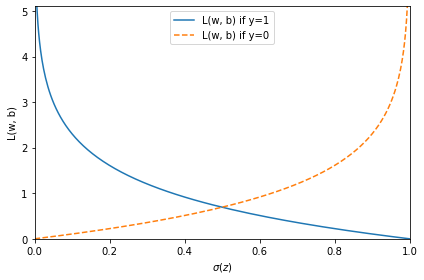

In [18]:
def plot_loss():
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss_1(z):
        return - np.log(sigmoid(z))
    
    def loss_0(z):
        return - np.log(1 - sigmoid(z))
    
    z = np.arange(-10, 10, 0.1)
    sigma_z = sigmoid(z)
    c1 = [loss_1(x) for x in z]
    plt.plot(sigma_z, c1, label='L(w, b) if y=1')
    c0 = [loss_0(x) for x in z]
    plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
    plt.ylim(0.0, 5.1)
    plt.xlim([0, 1])
    plt.xlabel('$\sigma(z)$')
    plt.ylabel('L(w, b)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
plot_loss()

### Implementing the logistic regression

The only difference between Adaline integration and logistic regression is the activiation function

In [23]:
class LogisticRegressionGD:
    
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta #learning rate
        self.n_iter = n_iter #number of epochs
        self.random_state = random_state #random state to initialize weights
        
    def fit(self, X, y):
        #X is a collection of training vectors and y is a collection of correct classifications
        #set initial weight and bias unit
        rgen = np.random.RandomState(self.random_state)
        # initialize weights as small, normally distributed, random values
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        #bias unit is set to zero initially
        self.b_ = np.float_(0.)
        #list to hold the loss function outputs
        self.losses_ = list()
        #move through the epochs
        for i in range(self.n_iter):
            #calculate the net input (i.e. z)
            net_input = self.net_input(X)
            #calculate the loss via the activation function
            output = self.activation(net_input)
            #calculate error as how far off the activation function was
            errors = y - output
            #update weights
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            #update bia unit
            self.b_ += self.eta * 2.0 * errors.mean()
            #calculate the loss
            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0])
            #add to the loss list
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        #calculates teh dot product to get the z for the decision function
        return np.dot(X, self.w_) + self.b_
    
    # THIS IS THE ONLY FUNCTION THAT IS DIFFERENT
    def activation(self, z):
        #activation for logistic regression is the sigmoid function
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        #the decision function
        return np.where(self.net_input(X) >= 0.5, 1, 0)

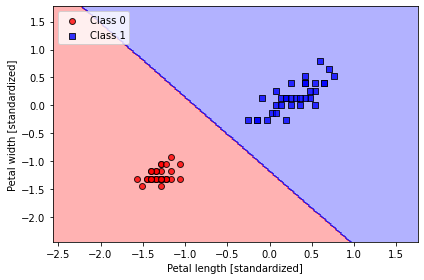

In [24]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,
    n_iter=1000,
    random_state=1)
lrgd.fit(X_train_01_subset,
    y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
    y=y_train_01_subset,
    classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()